In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
MIN_CAUSAL_SCORE = 0.3 # Top 5%
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

# Load mashR results
betas = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_betas.tsv"), sep="\t", index_col=0)
beta_ses = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_beta_ses.tsv"), sep="\t", index_col=0)
zscores = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "zscores.tsv"), sep="\t", index_col=0)
ntissues = len(betas.columns)

# Load eSTRs
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]


# Load master tables
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = sorted(list(COLORS.keys()))
TORDER = ["Adipose-Subcutaneous","Adipose-Visceral","Artery-Aorta","Artery-Tibial",
         "Lung","Nerve-Tibial","Thyroid","Skin-SunExposed","Skin-NotSunExposed","Esophagus-Mucosa",
         "Cells-Transformedfibroblasts","Muscle-Skeletal","Heart-LeftVentricle","Brain-Cerebellum","Brain-Caudate",
         "WholeBlood"]

# Master tables
master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval", 
                                     "linreg.significant",
                                     "anova.pval","caviar.str.score","caviar.str.rank","mashr.significant"])
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# TODO import from shared place
CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def GetEnrichCI(table, numsim=0):
    mult = 1 # +/- 1 stderr
    odds, pval = scipy.stats.fisher_exact(table)
    try:
        se_logOR = np.sqrt(1.0/table[0][0]+1.0/table[0][1]+1.0/table[1][0]+1.0/table[1][1])
        odds2 = table[0][0]*table[1][1]/(table[0][1]*table[1][0])
        odds_l = np.exp(np.log(odds2)-mult*se_logOR)
        odds_h = np.exp(np.log(odds2)+mult*se_logOR)
    except:
        odds2 = np.nan
        odds_l = np.nan
        odds_h = np.nan
    #print("%s (%s-%s)"%(odds2, odds_l, odds_h))
    return odds, pval, odds_l, odds_h

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True, numsim=0):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    odds_causal_low = []
    odds_causal_high = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal, o_causal_L, o_causal_H = GetEnrichCI(t_causal, numsim=numsim)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        odds_causal_low.append(o_causal_L)
        odds_causal_high.append(o_causal_H)
        pval_causal.append(p_causal)
        
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "odds.causal.low": odds_causal_low,
        "odds.causal.high": odds_causal_high,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)


In [3]:
# Get mashR results for only eSTRs
def FixIndex(val):
    items = val.split("_")
    return "%s_%s_%s"%(items[0].split(".")[0], items[1], items[2])
zscores.index = [FixIndex(item) for item in zscores.index]
betas.index = [FixIndex(item) for item in betas.index]

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
estrs_ind = causal.apply(lambda x: "%s_%s_%s"%(x["gene"], x["chrom"],x["str.start"]), 1)
zscores_estrs = zscores.loc[estrs_ind]
betas_estrs = betas.loc[estrs_ind]

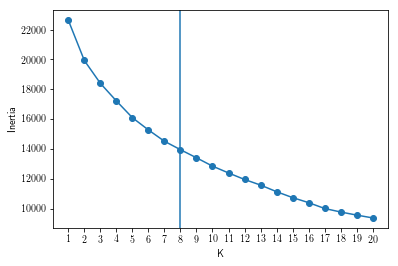

In [4]:
# Set up Z-normed data matrix
estrs_clust = abs(betas_estrs.copy())
means = estrs_clust.apply(np.mean, 1)
sds = estrs_clust.apply(lambda x: np.sqrt(np.var(x)), 1)
for t in TISSUES:
    estrs_clust[t] = (estrs_clust[t]-means)/sds
    
# Choose K
inertias = []
kvals = range(1, 21)
for k in kvals:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(estrs_clust)
    inertias.append(kmeans.inertia_)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kvals, inertias, marker="o")
ax.set_xticks(kvals)
ax.axvline(x=8)
ax.set_xlabel("K")
ax.set_ylabel("Inertia");

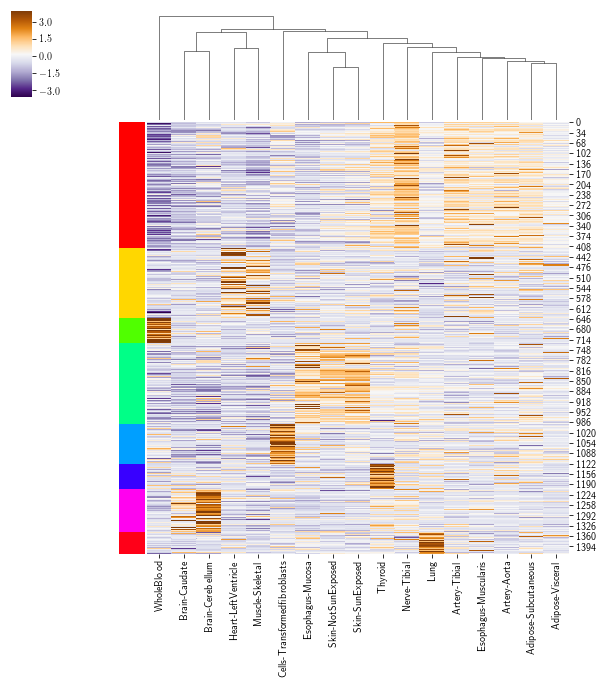

In [5]:
# Cluster eSTRs by tissue sharing pattern

# Set up clust again
estrs_clust = abs(betas_estrs.copy())
means = estrs_clust.apply(np.mean, 1)
sds = estrs_clust.apply(lambda x: np.sqrt(np.var(x)), 1)
for t in TISSUES:
    estrs_clust[t] = (estrs_clust[t]-means)/sds

K = 8 # seems reasonable from above
kmeans = KMeans(n_clusters=K, random_state=0).fit(estrs_clust)

estrs_clust["KClust"] = kmeans.labels_
estrs_clust = estrs_clust.sort_values("KClust")
estrs_clust["chrom"] = [x.split("_")[1] for x in estrs_clust.index]
estrs_clust["str.start"] = [int(x.split("_")[2]) for x in estrs_clust.index]
estrs_clust.index = range(estrs_clust.shape[0]) # else latex breaks in figure


# Plot zscores
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def GetColor(val):
    cmap = get_cmap(K)
    return cmap(val)

cluster_colors = [GetColor(val) for val in estrs_clust["KClust"]]
cg = sns.clustermap(estrs_clust[TISSUES], cmap="PuOr_r", row_cluster=False, row_colors = cluster_colors)
cg.ax_row_dendrogram.set_visible(False)
cg.savefig(os.path.join(RESULTSDIR, "Figure2_TissueClusters.pdf"))

# Motif enrichment

In [6]:
# Setup
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# Background of only eSTRs
ref_motif = ref[["chrom","str.start","motif"]].copy()
ref_motif["annot"] = ref_motif["motif"]
ref_motif_estrs = pd.merge(ref_motif, estrs[["chrom","str.start"]], on=["chrom","str.start"]) # TODO .drop_duplicates()

motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
motifs = motifs[motifs["motif"] != "ACACAC"]
motifs = list(motifs[motifs["str.start"]>=10]["motif"])

In [7]:
# Overall motif enrichment
useBG = ref_motif

motif_enrich_all = GetEnrichments(useBG, estrs, causal, motifs, annot_col=True)
motif_enrich_all = motif_enrich_all[motif_enrich_all["num.causal"]>=3]
mdata = motif_enrich_all[["annot","odds.causal"]]
mdata.columns = ["annot","ALL"]

# Per tissue individually
tenrich_by_tissue = {}
for t in TORDER:
    d = master[t]
    tcausal = d[d["linreg.significant"] & (d["caviar.str.score"]>=MIN_CAUSAL_SCORE)]
    tcausal["beta"] = tcausal["linreg.beta"]
    tenrich = GetEnrichments(useBG, estrs, tcausal, motifs, annot_col=True)
    tenrich_by_tissue[t] = tenrich.copy()
    tenrich = tenrich[["annot","odds.causal"]]
    tenrich.ix[tenrich["odds.causal"]==0,"odds.causal"] = np.nan
    tenrich.columns = ["annot","odds.causal.%s"%t]
    mdata = pd.merge(mdata, tenrich[["annot","odds.causal.%s"%t]], on=["annot"])

clenrich_by_cl = {}
for clustid in range(K):
    eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==clustid][["chrom","str.start"]], on=["chrom","str.start"])
    clenrich = GetEnrichments(useBG, estrs, eclust, motifs, annot_col=True)
    clenrich_by_cl[clustid] = clenrich.copy()
    clenrich = clenrich[["annot","odds.causal"]]
    clenrich.ix[clenrich["odds.causal"]==0,"odds.causal"] = np.nan
    clenrich.columns = ["annot","odds.causal.Cluster%s"%clustid]
    mdata = pd.merge(mdata, clenrich[["annot","odds.causal.Cluster%s"%clustid]], on=["annot"])

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.

In [8]:
# debugging
#for c in range(8):
#    eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==c][["chrom","str.start"]], on=["chrom","str.start"])
#    x = eclust[["chrom","str.start","motif"]].drop_duplicates().sort_values("motif").groupby("motif", as_index=False).agg({"chrom": len})
#    x.columns = ["motif","count"]
#    x["perc"] = x["count"]*1.0/np.sum(x["count"])
#    x = x[x["motif"].apply(len)>1]
#    x = x[x["count"]>=5]
#    print("cluster %s"%(c+1))
#    print(x.sort_values("perc", ascending=False))


In [9]:
for clustid in range(K):
    d = clenrich_by_cl[clustid]
    d = d[d["pval.causal"]<=0.01]
    print("#### Cluster %s ####"%(clustid + 1))
    print(d.sort_values("pval.causal")[["annot","num.causal","num.total", "odds.causal","pval.causal"]]) #

#### Cluster 1 ####
     annot  num.causal  num.total  odds.causal  pval.causal
74  AGCCCC           2         29    22.470951     0.004160
95     CCG           4        195     6.375880     0.004166
71     AGC           4        236     5.247367     0.008091
#### Cluster 2 ####
   annot  num.causal  num.total  odds.causal  pval.causal
71   AGC           3        236     7.018812     0.009879
#### Cluster 3 ####
Empty DataFrame
Columns: [annot, num.causal, num.total, odds.causal, pval.causal]
Index: []
#### Cluster 4 ####
     annot  num.causal  num.total  odds.causal  pval.causal
90  CCCCCG           2         23    45.393407     0.001089
#### Cluster 5 ####
     annot  num.causal  num.total  odds.causal  pval.causal
95     CCG           4        195    20.591041     0.000057
92  CCCCGG           2         20   107.690104     0.000204
#### Cluster 6 ####
Empty DataFrame
Columns: [annot, num.causal, num.total, odds.causal, pval.causal]
Index: []
#### Cluster 7 ####
Empty DataFrame
Colu

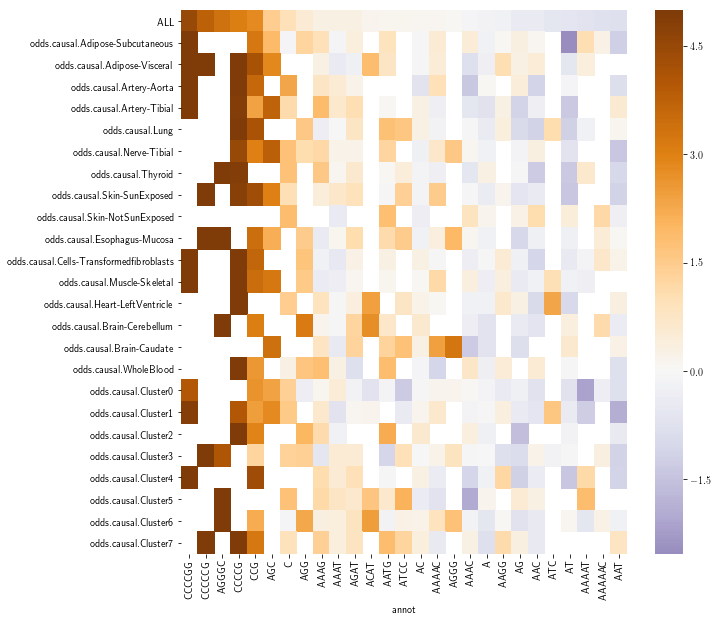

In [10]:
cols = ["ALL"]
for t in TORDER:
    cols.append("odds.causal.%s"%t)
for clustid in range(K):
    cols.append("odds.causal.Cluster%s"%clustid)
mdata = mdata.sort_values("ALL", ascending=False)
mdata.index = mdata["annot"]
mask = mdata[cols].isnull()

fig = plt.figure()
fig.set_size_inches((10,10))
ax = fig.add_subplot(111)
g = sns.heatmap(np.log2(mdata[cols].transpose()), cmap="PuOr_r", ax=ax, center=0, vmax=5);
fig.savefig(os.path.join(RESULTSDIR, "SuppFig_MotifsByTissue.pdf"))

In [11]:
# Motif enrichment - chi2

cluster_totals = []
for c in range(8):
    cluster_totals.append(estrs_clust[estrs_clust["KClust"]==c].shape[0])

pvals = []
usemotifs = list(set(causal["motif"])) #["A","T","AC","GT","AG","CT","CCG","CGG"]
for m in usemotifs: #["AAAAT","ACCCCC","CCGCTG", "T","CGGGGG"]:#usemotifs:
    motif_counts = []
    for c in range(8):
        x = pd.merge(estrs, estrs_clust[estrs_clust["KClust"]==c][["chrom","str.start"]], on=["chrom","str.start"]).drop_duplicates()
        motif_counts.append(x[x["motif"]==m].shape[0])
    notmotif_counts = [cluster_totals[i]-motif_counts[i] for i in range(len(cluster_totals))]
    if sum(motif_counts)<=1:
        p = np.nan
    else:
        try:
            p = scipy.stats.chi2_contingency([motif_counts, notmotif_counts])[1]
        except: p = np.nan
    pvals.append(p)
    print("%s: %s"%(m, p))
    print(motif_counts)
    print(["%.2f"%(motif_counts[i]*1.0/cluster_totals[i]) for i in range(len(cluster_totals))])

mchi = pd.DataFrame({"motif": usemotifs, "pvals": pvals})

ATTTT: 0.11646649988990734
[1, 1, 0, 0, 1, 2, 2, 0]
['0.00', '0.00', '0.00', '0.00', '0.01', '0.02', '0.01', '0.00']
AAAT: 0.25717656684418877
[27, 5, 3, 15, 11, 6, 9, 4]
['0.07', '0.02', '0.04', '0.06', '0.08', '0.07', '0.06', '0.06']
ACCCCC: 5.121457840837096e-05
[0, 0, 2, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.00', '0.00']
ATGG: 0.6565297066453104
[1, 0, 0, 1, 0, 1, 1, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.01', '0.00']
AGCCCG: nan
[0, 0, 0, 0, 0, 0, 1, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00']
AGGG: nan
[0, 0, 0, 0, 0, 0, 1, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00']
CCGGGG: 0.7095149168916355
[3, 1, 0, 0, 1, 0, 0, 0]
['0.01', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00']
AAAAAT: 0.049437821511037316
[3, 0, 0, 0, 0, 0, 3, 0]
['0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.02', '0.00']
AGGGG: nan
[0, 0, 1, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00'

ATGTT: nan
[1, 0, 0, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
ATTG: nan
[1, 0, 0, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
AAGG: 0.728499162172468
[3, 2, 0, 1, 0, 0, 2, 1]
['0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.01', '0.01']
AC: 0.17932280822237065
[75, 49, 14, 42, 27, 9, 20, 18]
['0.18', '0.21', '0.16', '0.16', '0.21', '0.11', '0.14', '0.25']
AAGGCC: nan
[1, 0, 0, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
GTTGTT: nan
[0, 0, 0, 0, 0, 0, 1, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00']
ATGT: 0.062113839985369
[1, 1, 0, 0, 0, 1, 3, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.02', '0.00']
ACCGCC: nan
[0, 0, 0, 0, 1, 0, 0, 0]
['0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00']
AGAGGG: nan
[1, 0, 0, 0, 0, 0, 0, 0]
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
AAGAG: nan
[0, 0, 0, 0, 0, 0, 1, 0]
['0.00

In [12]:
mchi = mchi[~np.isnan(mchi["pvals"])]
mchi[mchi["pvals"]<=0.05/mchi.shape[0]].sort_values("pvals")

,motif,pvals
45,AAAAT,8.136023e-11
2,ACCCCC,5.121458e-05
93,CCGCTG,5.121458e-05
55,T,2.855281e-04
34,CGGGGG,6.150476e-04


# Context motif enrichment

In [13]:
BUF = 100
for c in range(8):
    # Create BED files for each cluster
    x = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==c][["chrom","str.start"]], on=["chrom","str.start"])
    x["str.start"] = x["str.start"]-BUF
    x["str.end"] = x["str.end"]+BUF
    x[["chrom","str.start","str.end"]].drop_duplicates().to_csv("motifs/cluster_%s.bed"%(c+1), sep="\t", index=False, header=False)
    # Create FASTA files for each
    cmd = "bedtools getfasta -fi /storage/resources/dbase/human/hg19/hg19.fa -bed motifs/cluster_%s.bed > motifs/cluster_%s.fa"%(c+1,c+1)
    os.system(cmd)
# Concatenate all to get BG
x = causal.copy()
x["str.start"] = x["str.start"]-BUF
x["str.end"] = x["str.end"]+BUF
x[["chrom","str.start","str.end"]].drop_duplicates().to_csv("motifs/all.bed", sep="\t", index=False, header=False)
# Create FASTA files for each
cmd = "bedtools getfasta -fi /storage/resources/dbase/human/hg19/hg19.fa -bed motifs/all.bed > motifs/all.fa"
os.system(cmd)


0

In [14]:
%%bash
for cluster in $(seq 1 8)
do
    mkdir -p motifs/${cluster}/
    findMotifs.pl motifs/cluster_${cluster}.fa fasta motifs/${cluster}/ -fasta motifs/all.fa
done


Selected Options:
	Input file = motifs/cluster_1.fa
	Promoter Set = fasta
	Output Directory = motifs/1/
	Will use FASTA files for motif finding
		Target Sequences = motifs/cluster_1.fa
		Background Sequences = motifs/all.fa
	Parsing FASTA format files...
	Found 410 sequences
	Found 1380 sequences

	Progress: Step4 - removing redundant promoters

	Progress: Step5 - adjusting background sequences for GC/CpG content...

	Sequences processed:
		Auto detected maximum sequence length of 253 bp
		1790 total

	Frequency Bins: 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.6 0.7 0.8
	Freq	Bin	Count
	0.25	1	7
	0.3	2	69
	0.35	3	192
	0.4	4	334
	0.45	5	415
	0.5	6	355
	0.6	7	323
	0.7	8	44
	0.8	9	43
	10	10	8
	Bin	# Targets	# Background	Background Weight
	1	2	5	1.346
	2	19	50	1.279
	3	43	149	0.971
	4	77	257	1.008
	5	91	324	0.945
	6	75	280	0.902
	7	80	243	1.108
	8	12	32	1.262
	9	10	33	1.020
	10	1	7	0.481

	Normalizing lower order oligos using homer2

	Reading input files...
	1790 total sequences read
	Autonormaliza

# Cluster characterization

In [19]:
# Characterize clusters 
tspec = causal[["chrom","str.start","gene"]].copy()
tspec["ID"] = tspec.apply(lambda x: "%s_%s_%s"%(x["chrom"],x["str.start"], x["gene"]), 1)
tspec["num.analyzed"] = 0

for t in TISSUES:
    d = master[t]
    d = d[~np.isnan(d["linreg.pval"])]
    dids = set((d.apply(lambda x: "%s_%s_%s"%(x["chrom"],x["str.start"], x["gene"]), 1)))
    tspec.loc[tspec["ID"].apply(lambda x: x in dids), "num.analyzed"] += 1

In [20]:
num_analyzed_byclust = []
betas_by_clust = []

TORDER = ["Adipose-Subcutaneous","Adipose-Visceral","Artery-Aorta","Artery-Tibial",
         "Lung","Nerve-Tibial","Thyroid","Skin-SunExposed","Skin-NotSunExposed","Esophagus-Mucosa",
         "Cells-Transformedfibroblasts","Muscle-Skeletal","Heart-LeftVentricle","Brain-Cerebellum","Brain-Caudate",
         "WholeBlood"]
for clustid in range(K):
    # Num expressed in
    eclust = pd.merge(causal, estrs_clust[estrs_clust["KClust"]==clustid][["chrom","str.start"]], on=["chrom","str.start"])
    clust_ind = eclust.apply(lambda x: "%s_%s_%s"%(x["gene"], x["chrom"], x["str.start"]), 1)
    t = pd.merge(tspec, eclust[["chrom","str.start"]], on=["chrom","str.start"])
    num_analyzed_byclust.append(list(t["num.analyzed"]))
    
    # Distribution of betas for each tissue
    betas_by_tissue = []
    for t in TORDER:
        betas_by_tissue.append(betas.loc[clust_ind][t].apply(abs))
    betas_by_clust.append(betas_by_tissue)


17.0
17.0
16.0
17.0
17.0
17.0
17.0
17.0


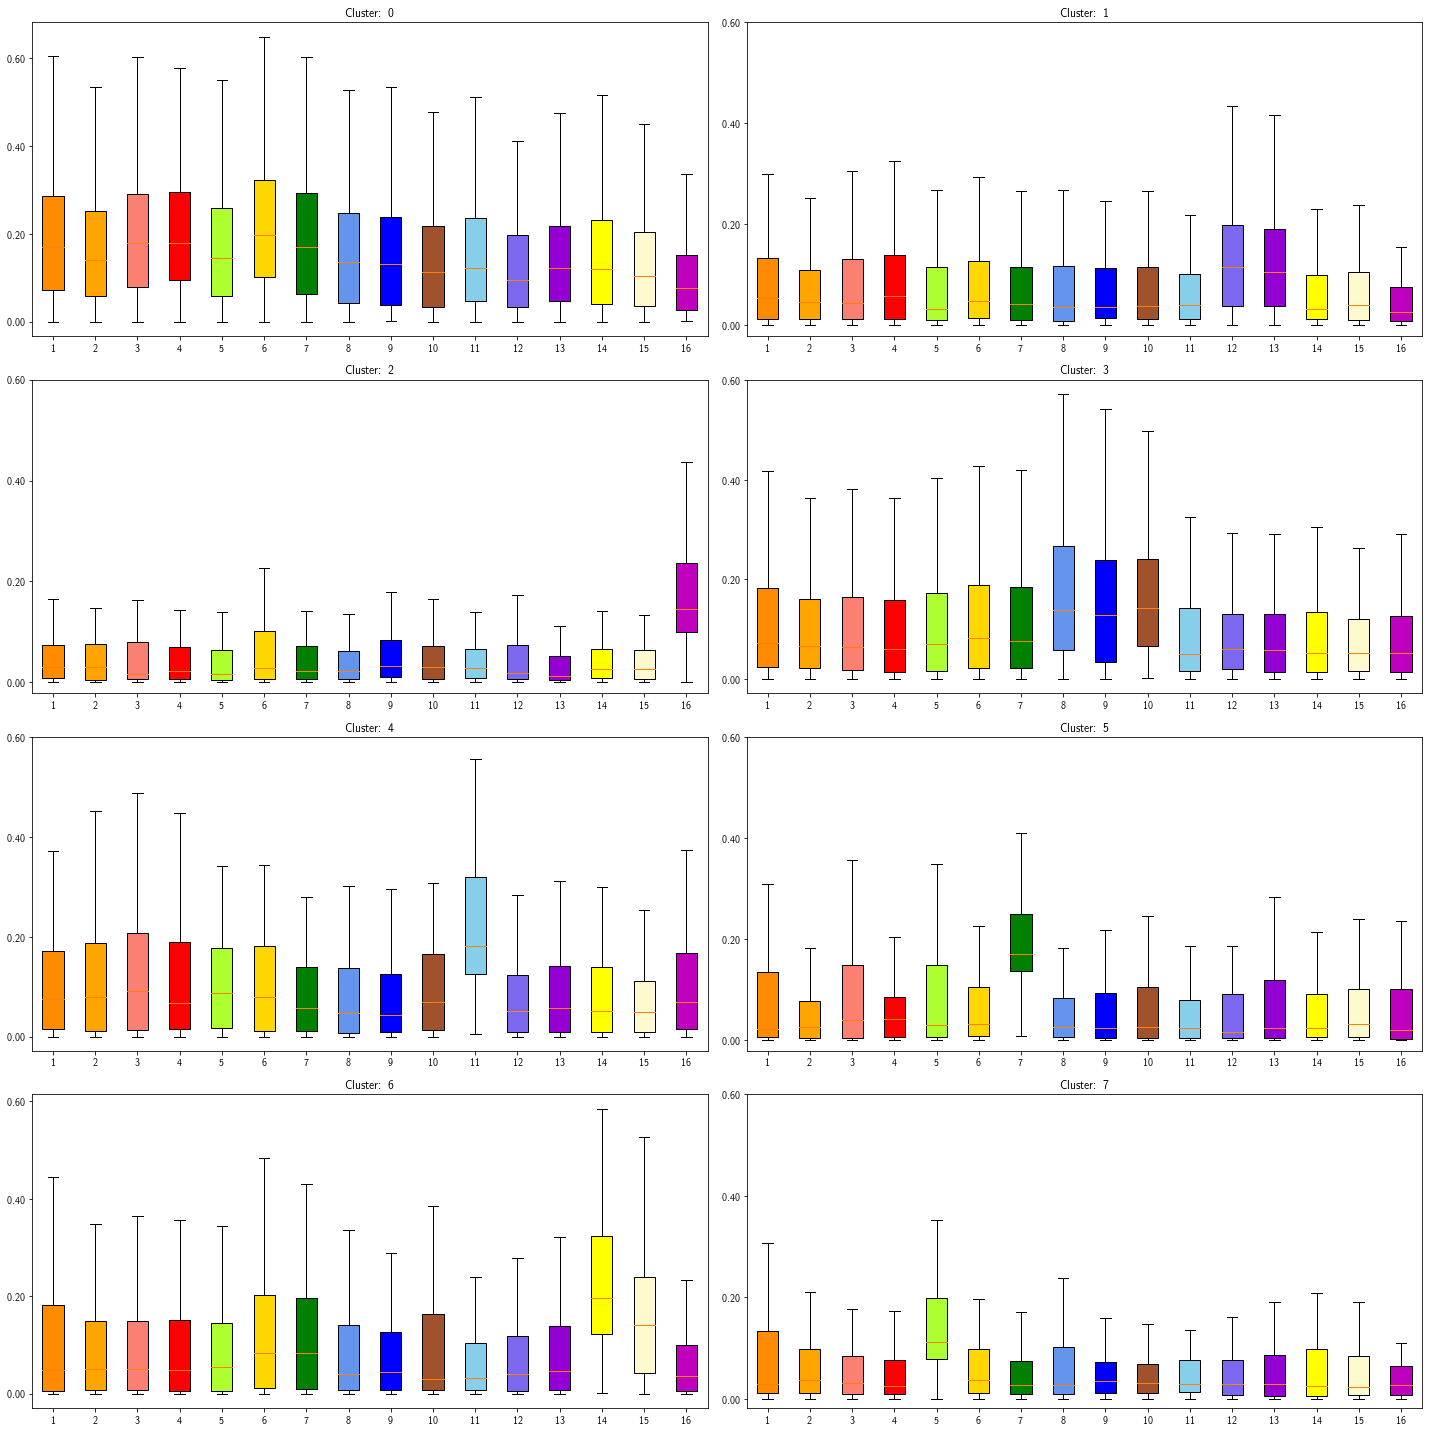

In [21]:
# num analyzed by cluster
for clustid in range(K):
    print(np.median(num_analyzed_byclust[clustid]))

# Beta values by tissue for each cluster
fig = plt.figure()
fig.set_size_inches((20, 20))
for clustid in range(K):
    ax = fig.add_subplot(4, 2, clustid+1)
    bp = ax.boxplot(betas_by_clust[clustid], sym="", patch_artist=True);
    colors = [COLORS[t] for t in TORDER]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title("Cluster: %s"%clustid)
    ax.set_yticks(np.arange(0, 0.61, 0.2))
    ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()])
fig.tight_layout()
fig.savefig(os.path.join(RESULTSDIR, "SuppFig_ClusterCharacteristics.pdf"))